# Modeling and Simulation in Python

Chapter 4: Predict

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### Functions from the previous chapter

In [2]:
def plot_estimates(table):
    """Plot world population estimates.
    
    table: DataFrame with columns 'un' and 'census'
    """
    un = table.un / 1e9
    census = table.census / 1e9
    
    plot(census, ':', color='darkblue', label='US Census')
    plot(un, '--', color='green', label='UN DESA')
    
    decorate(xlabel='Year',
             ylabel='World population (billion)')

In [3]:
def plot_model(system):
    """Plot the estimates and the model.
    
    system: system object with a system variable `model`
    """
    newfig()
    plot_estimates(table2)
    plot(system.model, '--', color='gray', label='model')
    decorate(xlabel='Year', 
             ylabel='World population (billion)')

In [4]:
def run_any_model(system, update_func):
    """Run a model.
    
    system: system object
    update_func: function that computes the population next year
    """
    model = Series([])
    model[system.t0] = system.p0
    for year in arange(system.t0, system.t_end):
        model[year+1] = update_func(year, model[year], system)
    system.model = model

### Reading the data

In [5]:
# The data directory contains a downloaded copy of
# https://en.wikipedia.org/wiki/World_population_estimates

from pandas import read_html
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')

In [6]:
table2 = tables[2]

In [7]:
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

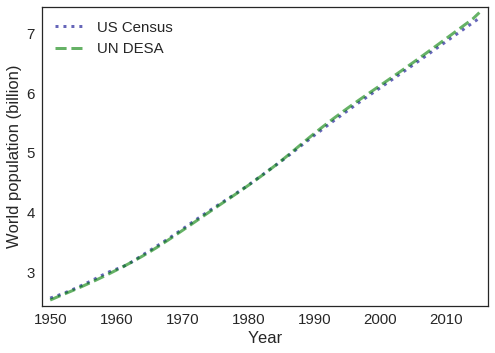

In [8]:
newfig()
plot_estimates(table2)

### Running the quadratic model

Here's the update function for the quadratic growth model with parameters `alpha` and `beta`.

In [9]:
def update_func3(year, pop, system):
    """Update population based on a quadratic model.
    
    year: what year it is
    pop: current population in billions
    system: system object with model parameters
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

Select the estimates generated by the U.S. Census, and convert to billions.

In [10]:
census = table2.census / 1e9

Extract the starting time and population.

In [11]:
t0 = census.index[0]
p0 = census[t0]
t_end = census.index[-1]

Initialize the system object.

In [12]:
system = System(t0=t0, 
                t_end=t_end,
                p0=p0,
                alpha = 0.025,
                beta = -0.0018)

system

,value
t0,1950.000000
t_end,2015.000000
p0,2.557629
alpha,0.025000
beta,-0.001800


Run the model and plot results.

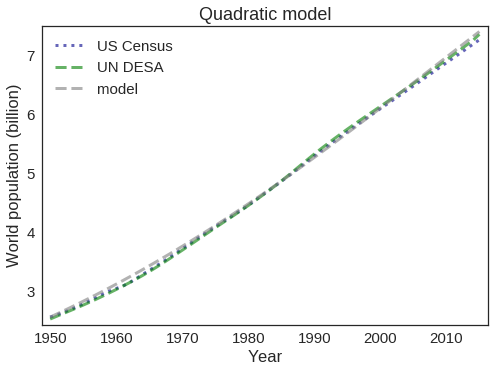

In [13]:
run_any_model(system, update_func3)
plot_model(system)
title('Quadratic model')

### Generating projections

To generate projections, all we have to do is change `t_end`

Saving figure to file chap04-fig01.pdf


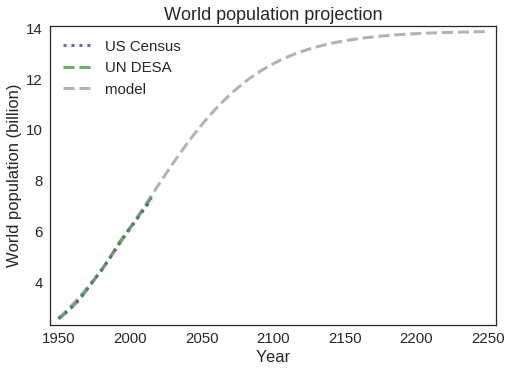

In [14]:
system.t_end = 2250
run_any_model(system, update_func3)
plot_model(system)
decorate(title='World population projection')
savefig('chap04-fig01.pdf')

The population in the model converges on the equilibrium population, `-alpha/beta`

In [15]:
system.model[system.t_end]

13.856665141368708

In [16]:
-system.alpha / system.beta

13.888888888888889

**Exercise:**  What happens if we start with an initial population above the carrying capacity, like 20 billion?  The the model with initial populations between 1 and 20 billion, and plot the results on the same axes.

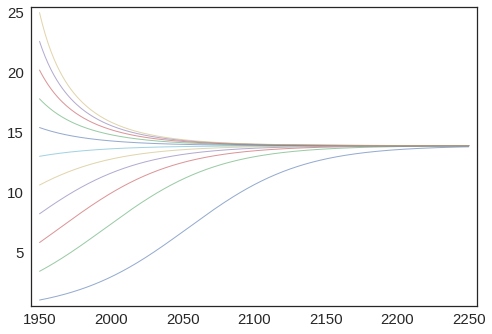

In [17]:
# Solution

newfig()
p0_array = linspace(1, 25, 11)

for system.p0 in p0_array:
    run_any_model(system, update_func3)
    plot(system.model, linewidth=1)

### Comparing projections

We can compare the projection from our model with projections produced by people who know what they are doing.

In [18]:
table3 = tables[3]
table3.head()

,United States Census Bureau (2015)[18],Population Reference Bureau (1973-2015)[6],United Nations Department of Economic and Social Affairs (2015)[7]
Year,,,
2016,7.334772e+09,NaN,7.432663e+09
2017,7.412779e+09,NaN,NaN
2018,7.490428e+09,NaN,NaN
2019,7.567403e+09,NaN,NaN
2020,7.643402e+09,NaN,7.758157e+09


`NaN` is a special value that represents missing data, in this case because some agencies did not publish projections for some years.

In [19]:
table3.columns = ['census', 'prb', 'un']

This function plots projections from the UN DESA and U.S. Census.  It uses `dropna` to remove the `NaN` values from each series before plotting it.

In [20]:
def plot_projections(table):
    """Plot world population projections.
    
    table: DataFrame with columns 'un' and 'census'
    """
    census = table.census / 1e9
    un = table.un / 1e9
    
    plot(census.dropna(), ':', color='darkblue', label='US Census')
    plot(un.dropna(), '--', color='green', label='UN DESA')

Run the model until 2100, which is as far as the other projections go.

In [21]:
system.p0 = census[t0]
system.t_end = 2100
run_any_model(system, update_func3)

Plot the results.

Saving figure to file chap04-fig02.pdf


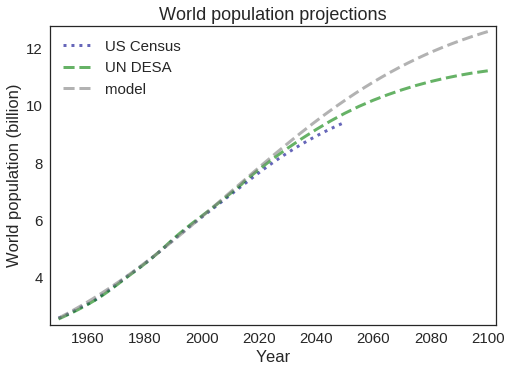

In [22]:
plot_model(system)
plot_projections(table3)
decorate(title='World population projections')
savefig('chap04-fig02.pdf')

People who know what they are doing expect the growth rate to decline more sharply than our model projects.

### Analysis with SymPy

The following lines set up Jupyter notebook to display math.

In [23]:
sympy.init_printing() 

And this function provides the option of showing results in LaTeX format.

In [24]:
from sympy.printing import latex

def show(expr, show_latex=False):
    if show_latex:
        print(latex(expr))
    return expr

Import the tools we'll need from SymPy

In [25]:
from sympy import symbols, Function, diff, Eq, dsolve

Create a symbol for time.

In [26]:
t = symbols('t')
show(t)

If you combine symbols and numbers, you get symbolic expressions.

In [27]:
expr = t + 1
show(expr)

The result is an Add object, which just represents the sum without trying to compute it.

In [28]:
type(expr)

sympy.core.add.Add

`subs` can be used to replace a symbol with a number, which allows the addition to proceed.

In [29]:
expr.subs(t, 2)

`f` is a special class of symbol that represents a function.

In [30]:
f = symbols('f', cls=Function)
show(f)

f

The type of `f` is `UndefinedFunction`

In [31]:
type(f)

sympy.core.function.UndefinedFunction

Now SymPy understands that `f(t)` means `f` evaluated at `t`, but it doesn't try to evaluate it yet.

In [32]:
f(t)

`diff` returns a `Derivative` object that represents the time derivative of `f`

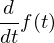

In [33]:
dfdt = diff(f(t), t)
show(dfdt)

In [34]:
type(dfdt)

sympy.core.function.Derivative

We need a symbol for `alpha`

In [35]:
alpha = symbols('alpha')
show(alpha)

Now we can write the differential equation for proportional growth.

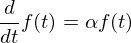

In [36]:
eq1 = Eq(dfdt, alpha*f(t))
show(eq1)

And use `dsolve` to solve it.  The result is the general solution.

In [37]:
solution_eq = dsolve(eq1)
show(solution_eq)

In this case, finding the particular solution is easy: we just replace `C1` with `p0`

In [38]:
C1, p0 = symbols(['C1', 'p0'])

In [39]:
particular = solution_eq.subs(C1, p0)
show(particular)

In the next example, we'll have to work a little harder to find the particular solution.

### Solving the quadratic growth equation 

We'll use the (r, K) parameterization, so we'll need two more symbols:

In [40]:
r, K = symbols(['r', 'K'])

Now we can write the differential equation.

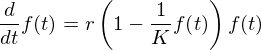

In [41]:
eq2 = Eq(diff(f(t), t), r*f(t) * (1 - f(t)/K))
show(eq2)

And solve it.

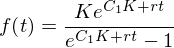

In [42]:
solution_eq = dsolve(eq2)
show(solution_eq)

`rhs` selects the right-hand side of the solution.

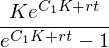

In [43]:
general = solution_eq.rhs
show(general)

We can evaluate the right-hand side at $t=0$

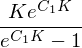

In [44]:
at0 = general.subs(t, 0)
show(at0)

Now we want to find the value of `C1` that makes `f(0) = p0`.

So we'll create the equation `at0 = p0` and solve for `C1`.  Because this is just an algebraic identity, not a differential equation, we use `solve`, not `dsolve`.

In [45]:
from sympy import solve

The result from `solve` is a sequence of solutions.  In this case, [we have reason to expect only one solution](https://en.wikipedia.org/wiki/Picard%E2%80%93Lindel%C3%B6f_theorem), but we still get a sequence, so we have to use `[0]` to select the first one.

In [46]:
solutions = solve(Eq(at0, p0), C1)
type(solutions), len(solutions)

(list, 1)

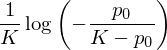

In [47]:
value_of_C1 = solutions[0]
show(value_of_C1)

Now in the general solution, we want to replace `C1` with the value of `C1` we just figured out.

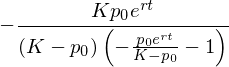

In [48]:
particular = general.subs(C1, value_of_C1)
particular

The result is complicated, but SymPy provides a method that tries to simplify it.

In [49]:
from sympy import simplify

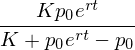

In [50]:
particular = simplify(particular)
show(particular)

Often simplicity is in the eye of the beholder, but that's about as simple as this expression gets.

Just to double-check, we can evaluate it at `t=0` and confirm that we get `p0`

In [51]:
particular.subs(t, 0)

[In some places](https://en.wikipedia.org/wiki/Population_growth#Logistic_equation) you'll see this solution, which is called the "logistic function" written in a different form:

$f(t) = \frac{K}{1 + A e^{-rt}}$

where $A = (K - p_0) / p_0$.

We can use SymPy to confirm that these two forms are equivalent.


First, we need to import a version of `exp` that works with SymPy symbols.

In [52]:
from sympy import exp

Now we can represent the alternative version of the logistic function:

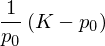

In [53]:
A = (K - p0) / p0
show(A)

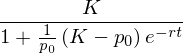

In [54]:
logistic = K / (1 + A * exp(-r*t))
show(logistic)

To see whether two expressions are equivalent, we can check whether their difference simplifies to 0.

In [55]:
simplify(particular - logistic)

This test only works one way: if SymPy says the difference reduces to 0, the expressions are definitely equivalent (and not just numerically close).

But if SymPy can't find a way to simplify the result to 0, that doesn't necessarily mean there isn't one.  Testing whether two expressions is a surprisingly hard problem; in fact, there is no algorithm that can solve it in general.

**Exercise:** Solve the quadratic growth equation using the alternative parameterization

$\frac{df(t)}{dt} = \alpha f(t) + \beta f^2(t) $

In [56]:
# Solution

alpha, beta = symbols(['alpha', 'beta'])

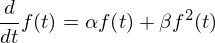

In [57]:
# Solution

eq3 = Eq(diff(f(t), t), alpha*f(t) + beta*f(t)**2)
eq3

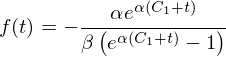

In [58]:
# Solution

solution_eq = dsolve(eq3)
solution_eq

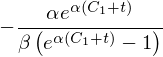

In [59]:
# Solution

general = solution_eq.rhs
general

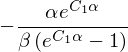

In [60]:
# Solution

at0 = general.subs(t, 0)
at0

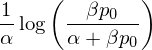

In [61]:
# Solution

solutions = solve(Eq(at0, p0), C1)
value_of_C1 = solutions[0]
value_of_C1

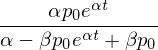

In [62]:
# Solution

particular = general.subs(C1, value_of_C1)
particular.simplify()

**Exercise:**  Use [WolframAlpha](https://www.wolframalpha.com/) to solve the quadratic growth model, using either or both forms of parameterization:

    df(t) / dt = alpha f(t) + beta f(t)^2

or

    df(t) / dt = alpha f(t) (1 - f(t)/K)

Query the general solution and also the particular solution where `f(0) = p0`.

**Exercise:**  Suppose there are two banks across the street from each other, The First Geometric Bank (FGB) and Exponential Savings and Loan (ESL).  They offer the same interest rate on checking accounts, 3%, but at FGB, they compute and pay interest at the end of each year, and at ESL they compound interest continuously.

If you deposit $p_0$ dollars at FGB at the beginning of Year 0, the balanace of your account at the end of Year $n$ is

$ x_n = p_0 (1 + \alpha)^n $

where $\alpha = 0.03$.  At ESL, your balance at any time $t$ would be

$ x(t) = p_0 \exp(\alpha t) $

If you deposit \$1000 at each back at the beginning of Year 0, how much would you have in each account after 10 years?

Is there an interest rate FGB could pay so that your balance at the end of each year would be the same at both banks?  What is it?

In [63]:
# Solution

p0 = 1000
alpha = 0.03

In [64]:
# Solution

ts = arange(11)

In [65]:
# Solution

geometric = p0 * (1 + alpha) ** ts
geometric

array([ 1000.        ,  1030.        ,  1060.9       ,  1092.727     ,
        1125.50881   ,  1159.2740743 ,  1194.05229653,  1229.87386542,
        1266.77008139,  1304.77318383,  1343.91637934])

In [66]:
# Solution

exponential = p0 * np.exp(alpha * ts)
exponential

array([ 1000.        ,  1030.45453395,  1061.83654655,  1094.17428371,
        1127.49685158,  1161.83424273,  1197.21736312,  1233.67805996,
        1271.24915032,  1309.96445073,  1349.85880758])

In [67]:
# Solution

alpha2 = np.exp(alpha) - 1
alpha2

In [68]:
# Solution

geometric = p0 * (1 + alpha2) ** ts
geometric

array([ 1000.        ,  1030.45453395,  1061.83654655,  1094.17428371,
        1127.49685158,  1161.83424273,  1197.21736312,  1233.67805996,
        1271.24915032,  1309.96445073,  1349.85880758])

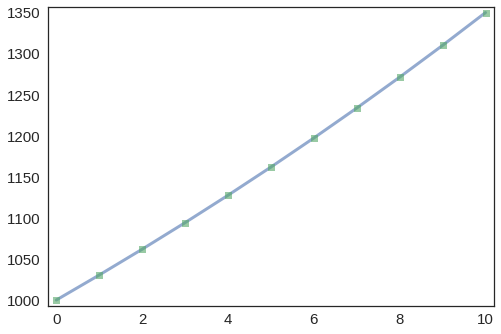

In [69]:
# Solution

newfig()
plot(ts, exponential, '-')
plot(ts, geometric, 's')

**Exercise:** Suppose a new bank opens called the Polynomial Credit Union (PCU).  In order to compete with First Geometric Bank and Exponential Savings and Loan, PCU offers a parabolic savings account where the balance is a polynomial function of time:

$ x(t) = p_0 + \beta_1 t + \beta_2 t^2 $

As a special deal, they offer an account with $\beta_1 = 30$ and $\beta_2 = 0.5$, with those parameters guaranteed for life.

Suppose you deposit \$1000 at all three banks at the beginning of Year 0.  How much would you have in each account at the end of Year 10?  How about Year 20?  And Year 100?

In [70]:
# Solution

number_of_years = 100
ts = arange(number_of_years+1)
geometric = p0 * (1 + alpha2) ** ts
exponential = p0 * np.exp(alpha * ts)

In [71]:
# Solution

beta1 = 30
beta2 = 0.5
parabolic = p0 + beta1 * ts + beta2 * ts**2
parabolic

array([ 1000. ,  1030.5,  1062. ,  1094.5,  1128. ,  1162.5,  1198. ,
        1234.5,  1272. ,  1310.5,  1350. ,  1390.5,  1432. ,  1474.5,
        1518. ,  1562.5,  1608. ,  1654.5,  1702. ,  1750.5,  1800. ,
        1850.5,  1902. ,  1954.5,  2008. ,  2062.5,  2118. ,  2174.5,
        2232. ,  2290.5,  2350. ,  2410.5,  2472. ,  2534.5,  2598. ,
        2662.5,  2728. ,  2794.5,  2862. ,  2930.5,  3000. ,  3070.5,
        3142. ,  3214.5,  3288. ,  3362.5,  3438. ,  3514.5,  3592. ,
        3670.5,  3750. ,  3830.5,  3912. ,  3994.5,  4078. ,  4162.5,
        4248. ,  4334.5,  4422. ,  4510.5,  4600. ,  4690.5,  4782. ,
        4874.5,  4968. ,  5062.5,  5158. ,  5254.5,  5352. ,  5450.5,
        5550. ,  5650.5,  5752. ,  5854.5,  5958. ,  6062.5,  6168. ,
        6274.5,  6382. ,  6490.5,  6600. ,  6710.5,  6822. ,  6934.5,
        7048. ,  7162.5,  7278. ,  7394.5,  7512. ,  7630.5,  7750. ,
        7870.5,  7992. ,  8114.5,  8238. ,  8362.5,  8488. ,  8614.5,
        8742. ,  887

In [72]:
# Solution

def plot_results(**options):
    newfig()
    plot(ts, exponential, '-', label='exponential')
    plot(ts, geometric, 's', label='geometric')
    plot(ts, parabolic, 'o', label='parabolic')
    decorate(xlabel='Year', ylabel='Balance (USD)', **options)

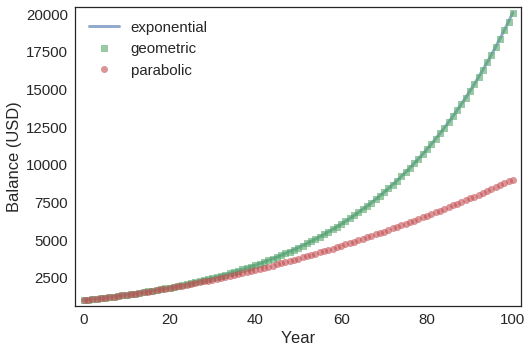

In [73]:
# Solution

plot_results()

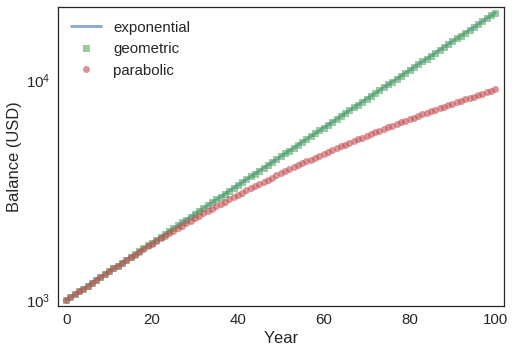

In [74]:
# Solution

plot_results(yscale='log')

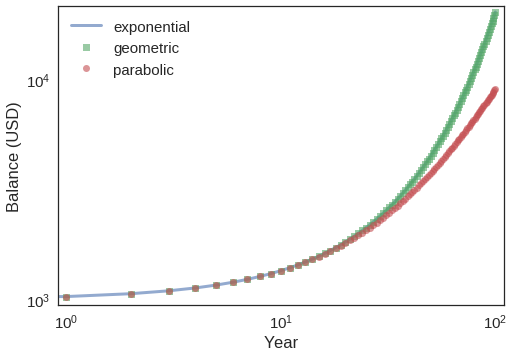

In [75]:
# Solution

plot_results(xscale='log', yscale='log')